In [1]:

# ==========================================
# Imports and Setup
# ==========================================

import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time
from datetime import datetime

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

print("Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA version: {torch.version.cuda}")

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUsing device: {device}")

Libraries imported successfully!
PyTorch version: 2.9.0+cu126
NumPy version: 2.0.2
CUDA available: True
GPU: Tesla T4
CUDA version: 12.6

Using device: cuda


In [2]:

# ==========================================
# Utility Functions
# ==========================================

def plot_loss(train_loss, test_loss=None, fs=14, lw=2, savefile=None, figsize=(10, 5)):
    """Plot training and test loss curves."""
    plt.figure(figsize=figsize)
    plt.plot(train_loss, label='Train Loss', linewidth=lw, color='blue')
    if test_loss is not None:
        plt.plot(test_loss, label='Test Loss', linewidth=lw, color='red')
    plt.xlabel('Epoch', fontsize=fs)
    plt.ylabel('MSE Loss', fontsize=fs)
    plt.yscale('log')
    plt.legend(fontsize=fs)
    plt.grid(True, alpha=0.3)
    plt.title('Training History', fontsize=fs+2, fontweight='bold')
    plt.tight_layout()
    if savefile:
        plt.savefig(savefile, dpi=150, bbox_inches='tight')
        print(f"Loss plot saved to {savefile}")
    plt.show()


def plot_2d_field(ax, u, extent=[0, 2*np.pi, 0, 2*np.pi], cmap='jet',
                  vmin=None, vmax=None, title=None, xlabel='x', ylabel='y'):
    """Plot a 2D field with colorbar."""
    im = ax.imshow(u, origin='lower', extent=extent, cmap=cmap,
                   vmin=vmin, vmax=vmax, aspect='auto', interpolation='bilinear')
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    if title:
        ax.set_title(title, fontsize=12, fontweight='bold')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    return im


def compute_relative_l2_error(pred, truth):
    """Compute relative L2 error: ||pred - truth|| / ||truth||"""
    return np.linalg.norm(pred - truth) / np.linalg.norm(truth)


print("Utility functions defined!")

Utility functions defined!


In [3]:
# ==========================================
# Dataset Class
# ==========================================

class BurgersDataset(Dataset):
    """Memory-efficient dataset for Burgers equation DeepONet training."""

    def __init__(self, u0_data, trunk_data, u_data, device='cpu'):
        """
        Parameters:
        -----------
        u0_data : torch.Tensor, shape (N, nx*ny)
            Initial conditions (branch input), already flattened
        trunk_data : torch.Tensor, shape (M, 3)
            Trunk coordinates (x, y, t) - SHARED across all samples
        u_data : torch.Tensor, shape (N, M)
            Solution values at trunk points
        """
        self.u0_data = u0_data.to(device)
        self.trunk_data = trunk_data.to(device)  # Store but don't return in __getitem__
        self.u_data = u_data.to(device)
        self.device = device

    def __len__(self):
        return len(self.u0_data)

    def __getitem__(self, idx):
        # Return only u0 and u (solution), NOT trunk
        # Trunk is the same for all samples and will be passed separately
        return (self.u0_data[idx],      # Already flattened initial condition
                self.u_data[idx])        # Solution at all trunk points


print("Dataset class defined!")

Dataset class defined!


In [4]:
# ==========================================
# DeepONet Architecture
# ==========================================

# ---------- CNN-BASED BRANCH NETWORK (CHANGE) ----------
class BranchNet(nn.Module):
    """
    Improved CNN-based branch for DeepONet.
    Preserves tensor structure and increases operator capacity.
    """
    def __init__(self, in_channels, branch_out_dim):
        super(BranchNet, self).__init__()
        self.branch_out_dim = branch_out_dim

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, padding=1),
            nn.Tanh(),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.Tanh(),

            # 🔥 NEW BLOCK (critical improvement)
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.Tanh(),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.Tanh(),

            nn.AdaptiveAvgPool2d((4, 4))
        )

        # 256 feature maps × 4 × 4 = 4096
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 256),
            nn.Tanh(),
            nn.Linear(256, branch_out_dim)
        )

    def forward(self, x):
        features = self.conv(x)
        out = self.fc(features)
        return out




class TrunkNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),

            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),

            # 🔥 NEW LAYER (Priority 3)
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),

            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.net(x)



class DeepONet(nn.Module):
    """Deep Operator Network for Burgers equation with memory-efficient chunked processing"""
    def __init__(self, branch_input_dim, trunk_input_dim, hidden_dim, p, chunk_size=2048):
        super(DeepONet, self).__init__()
        self.branch = BranchNet(branch_input_dim, p)
        self.trunk = TrunkNet(trunk_input_dim, hidden_dim, p)
        self.bias = nn.Parameter(torch.zeros(1))
        self.p = p
        self.chunk_size = chunk_size

def forward(self, u0, xyt):
        """
        Memory-efficient forward pass with chunked trunk processing

        u0: (batch_size, C, H, W)    # CHANGED: tensorial initial condition
        xyt: (num_trunk_points, trunk_input_dim)
        """
        batch_size = u0.shape[0]
        num_trunk = xyt.shape[0]

        # Encode branch (initial conditions)
        b = self.branch(u0)  # (batch_size, p)  # CHANGED: branch is now CNN taking (B,C,H,W)

        # Process trunk in chunks to save memory
        outputs = []
        for i in range(0, num_trunk, self.chunk_size):
            end_idx = min(i + self.chunk_size, num_trunk)
            xyt_chunk = xyt[i:end_idx]  # (chunk_size, trunk_input_dim)

            # Encode trunk chunk
            t_chunk = self.trunk(xyt_chunk)  # (chunk_size, p)

            # Compute output for this chunk
            out_chunk = torch.matmul(b, t_chunk.T)  # (batch_size, chunk_size)
            outputs.append(out_chunk)

        # Concatenate all chunks
        out = torch.cat(outputs, dim=1) + self.bias  # (batch_size, num_trunk_points)
        return out


print("DeepONet architecture defined with chunked processing!")

DeepONet architecture defined with chunked processing!


# **DATA GENERATION CODE**

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

class Burgers2DSolver:
    def __init__(self, nx=64, ny=64, T=1.0, nt=200, nu=0.5,
                 length=2*np.pi, dealias=True):

        self.nx, self.ny = int(nx), int(ny)
        self.T, self.nt = float(T), int(nt)
        self.nu = float(nu)
        self.length = float(length)
        self.dealias = bool(dealias)

        self.dt = self.T / (self.nt - 1)

        # physical grid
        self.x = np.linspace(0, self.length, self.nx, endpoint=False)
        self.y = np.linspace(0, self.length, self.ny, endpoint=False)

        # spectral grid
        kx = 2*np.pi*np.fft.fftfreq(self.nx, d=self.length/self.nx)
        ky = 2*np.pi*np.fft.fftfreq(self.ny, d=self.length/self.ny)
        self.KX, self.KY = np.meshgrid(kx, ky, indexing="ij")
        self.K2 = self.KX**2 + self.KY**2

        self.t = np.linspace(0, self.T, self.nt)

        # 2/3 dealiasing mask
        if self.dealias:
            k_mag = np.sqrt(self.K2)
            k_cut = (2/3)*np.max(k_mag)
            self.mask = (k_mag <= k_cut).astype(float)
        else:
            self.mask = np.ones_like(self.K2)

        # diffusion integrating factor
        self.exp_factor = np.exp(-self.nu * self.K2 * self.dt)

    def generate_initial_condition(self, num_samples,
                                   l=0.6, sigma=1.0, seed=None):
        if seed is not None:
            np.random.seed(seed)

        u0s = np.zeros((num_samples, self.nx, self.ny))

        for i in tqdm(range(num_samples), desc="Generating ICs"):
            noise = np.random.randn(self.nx, self.ny)
            noise_hat = np.fft.fft2(noise)
            envelope = np.exp(-0.5*(l**2)*self.K2)
            u0 = np.real(np.fft.ifft2(noise_hat * envelope))
            u0 = (u0 - u0.mean()) / (u0.std() + 1e-12)
            u0s[i] = sigma * u0

        return u0s

    def nonlinear_hat(self, u_hat):
        ux_hat = 1j * self.KX * u_hat
        uy_hat = 1j * self.KY * u_hat

        u  = np.real(np.fft.ifft2(u_hat))
        ux = np.real(np.fft.ifft2(ux_hat))
        uy = np.real(np.fft.ifft2(uy_hat))

        nl = u * (ux + uy)
        nl_hat = np.fft.fft2(nl)

        if self.dealias:
            nl_hat *= self.mask

        return nl_hat

    def solve(self, u0, verbose=False):
        u_hat = np.fft.fft2(u0)
        sol = np.zeros((self.nt, self.nx, self.ny))
        sol[0] = u0.copy()

        for n in range(1, self.nt):
            k1 = -self.nonlinear_hat(u_hat)
            k2 = -self.nonlinear_hat(u_hat + 0.5*self.dt*k1)
            k3 = -self.nonlinear_hat(u_hat + 0.5*self.dt*k2)
            k4 = -self.nonlinear_hat(u_hat + self.dt*k3)

            u_hat = u_hat + (self.dt/6)*(k1 + 2*k2 + 2*k3 + k4)
            u_hat = u_hat * self.exp_factor

            if not np.isfinite(u_hat).all():
                if verbose:
                    print(f"Instability at step {n}")
                return None

            sol[n] = np.real(np.fft.ifft2(u_hat))

        return sol

def generate_burgers_data(
    num_samples=500,
    nx=64, ny=64,
    nt=200,
    nu=0.5,
    out_file="Burgers2D_samples_large.npz",
    seed=1,
    normalize=True,
    verbose=True
):

    solver = Burgers2DSolver(nx, ny, T=1.0, nt=nt, nu=nu)
    u0s = solver.generate_initial_condition(num_samples, seed=seed)

    solutions, valid_u0 = [], []

    for i in tqdm(range(num_samples), desc="Solving"):
        sol = solver.solve(u0s[i], verbose=verbose)
        if sol is not None:
            solutions.append(sol)
            valid_u0.append(u0s[i])

    if len(solutions) == 0:
        raise RuntimeError("All solutions unstable — check parameters.")

    solutions = np.array(solutions)
    valid_u0 = np.array(valid_u0)

    if normalize:
        sol_mean, sol_std = solutions.mean(), solutions.std() + 1e-12
        u0_mean, u0_std = valid_u0.mean(), valid_u0.std() + 1e-12
        solutions = (solutions - sol_mean) / sol_std
        valid_u0 = (valid_u0 - u0_mean) / u0_std
    else:
        sol_mean = sol_std = u0_mean = u0_std = 0.0

    np.savez_compressed(
        out_file,
        u0_samples=valid_u0,
        solutions=solutions,
        t=solver.t,
        x=solver.x,
        y=solver.y,
        sol_mean=sol_mean,
        sol_std=sol_std,
        u0_mean=u0_mean,
        u0_std=u0_std
    )

    print(f"Saved dataset → {out_file}")
    return valid_u0, solutions


# ============================================================
# Demo
# ============================================================
if __name__ == "__main__":
    # Check if file exists to save time, otherwise generate
    if not os.path.exists("Burgers2D_samples_large.npz"):
        generate_burgers_data()
    else:
        print("Dataset already exists.")


Solving: 100%|██████████| 500/500 [03:29<00:00,  2.38it/s]


Saved dataset → Burgers2D_samples_large.npz


In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# import os
# from tqdm import tqdm
# import warnings
# warnings.filterwarnings("ignore")


# # ============================================================
# # 2D Burgers Pseudo-Spectral Solver
# # ============================================================
# class Burgers2DSolver:
#     def __init__(self, nx=64, ny=64, T=1.0, nt=200, nu=0.5,
#                  length=2*np.pi, dealias=True):

#         self.nx, self.ny = int(nx), int(ny)
#         self.T, self.nt = float(T), int(nt)
#         self.nu = float(nu)
#         self.length = float(length)
#         self.dealias = bool(dealias)

#         self.dt = self.T / (self.nt - 1)

#         # physical grid
#         self.x = np.linspace(0, self.length, self.nx, endpoint=False)
#         self.y = np.linspace(0, self.length, self.ny, endpoint=False)

#         # spectral grid
#         kx = 2*np.pi*np.fft.fftfreq(self.nx, d=self.length/self.nx)
#         ky = 2*np.pi*np.fft.fftfreq(self.ny, d=self.length/self.ny)
#         self.KX, self.KY = np.meshgrid(kx, ky, indexing="ij")
#         self.K2 = self.KX**2 + self.KY**2

#         self.t = np.linspace(0, self.T, self.nt)

#         # 2/3 dealiasing mask
#         if self.dealias:
#             k_mag = np.sqrt(self.K2)
#             k_cut = (2/3)*np.max(k_mag)
#             self.mask = (k_mag <= k_cut).astype(float)
#         else:
#             self.mask = np.ones_like(self.K2)

#         # diffusion integrating factor
#         self.exp_factor = np.exp(-self.nu * self.K2 * self.dt)

#     def generate_initial_condition(self, num_samples,
#                                    l=0.6, sigma=1.0, seed=None):
#         if seed is not None:
#             np.random.seed(seed)

#         u0s = np.zeros((num_samples, self.nx, self.ny))

#         for i in tqdm(range(num_samples), desc="Generating ICs"):
#             noise = np.random.randn(self.nx, self.ny)
#             noise_hat = np.fft.fft2(noise)
#             envelope = np.exp(-0.5*(l**2)*self.K2)
#             u0 = np.real(np.fft.ifft2(noise_hat * envelope))
#             u0 = (u0 - u0.mean()) / (u0.std() + 1e-12)
#             u0s[i] = sigma * u0

#         return u0s

#     def nonlinear_hat(self, u_hat):
#         ux_hat = 1j * self.KX * u_hat
#         uy_hat = 1j * self.KY * u_hat

#         u  = np.real(np.fft.ifft2(u_hat))
#         ux = np.real(np.fft.ifft2(ux_hat))
#         uy = np.real(np.fft.ifft2(uy_hat))

#         nl = u * (ux + uy)
#         nl_hat = np.fft.fft2(nl)

#         if self.dealias:
#             nl_hat *= self.mask

#         return nl_hat

#     def solve(self, u0, verbose=False):
#         u_hat = np.fft.fft2(u0)
#         sol = np.zeros((self.nt, self.nx, self.ny))
#         sol[0] = u0.copy()

#         for n in range(1, self.nt):
#             k1 = -self.nonlinear_hat(u_hat)
#             k2 = -self.nonlinear_hat(u_hat + 0.5*self.dt*k1)
#             k3 = -self.nonlinear_hat(u_hat + 0.5*self.dt*k2)
#             k4 = -self.nonlinear_hat(u_hat + self.dt*k3)

#             u_hat = u_hat + (self.dt/6)*(k1 + 2*k2 + 2*k3 + k4)
#             u_hat = u_hat * self.exp_factor

#             if not np.isfinite(u_hat).all():
#                 if verbose:
#                     print(f"Instability at step {n}")
#                 return None

#             sol[n] = np.real(np.fft.ifft2(u_hat))

#         return sol


# # ============================================================
# # Dataset Generator
# # ============================================================
# def generate_burgers_data(
#     num_samples=40,
#     nx=64, ny=64,
#     nt=200,
#     nu=0.5,
#     out_file="Burgers2D_samples.npz",
#     seed=1,
#     normalize=True,
#     verbose=True
# ):

#     solver = Burgers2DSolver(nx, ny, T=1.0, nt=nt, nu=nu)
#     u0s = solver.generate_initial_condition(num_samples, seed=seed)

#     solutions, valid_u0 = [], []

#     for i in tqdm(range(num_samples), desc="Solving"):
#         sol = solver.solve(u0s[i], verbose=verbose)
#         if sol is not None:
#             solutions.append(sol)
#             valid_u0.append(u0s[i])

#     if len(solutions) == 0:
#         raise RuntimeError("All solutions unstable — check parameters.")

#     solutions = np.array(solutions)
#     valid_u0 = np.array(valid_u0)

#     if normalize:
#         sol_mean, sol_std = solutions.mean(), solutions.std() + 1e-12
#         u0_mean, u0_std = valid_u0.mean(), valid_u0.std() + 1e-12
#         solutions = (solutions - sol_mean) / sol_std
#         valid_u0 = (valid_u0 - u0_mean) / u0_std
#     else:
#         sol_mean = sol_std = u0_mean = u0_std = 0.0

#     np.savez_compressed(
#         out_file,
#         u0_samples=valid_u0,
#         solutions=solutions,
#         t=solver.t,
#         x=solver.x,
#         y=solver.y,
#         sol_mean=sol_mean,
#         sol_std=sol_std,
#         u0_mean=u0_mean,
#         u0_std=u0_std
#     )

#     print(f"Saved dataset → {out_file}")
#     return valid_u0, solutions


# # ============================================================
# # Demo
# # ============================================================
# if __name__ == "__main__":
#     generate_burgers_data()


Solving: 100%|██████████| 40/40 [00:16<00:00,  2.44it/s]


Saved dataset → Burgers2D_samples.npz


In [7]:

# ==========================================
# Data Loading (Memory-Efficient & Dynamic)
# ==========================================

import torch
import numpy as np
import os
from torch.utils.data import DataLoader

# Load data with memory mapping
data_path = 'Burgers2D_samples_large.npz'
print(f"Loading data from {data_path} (memory-mapped mode)...")

# Check if file exists to avoid crashes
if not os.path.exists(data_path):
    print("Data file not found! Generating data now...")
    generate_burgers_data()

data = np.load(data_path, mmap_mode='r')  # Memory-mapped read
print(f"Keys in data file: {list(data.keys())}")

# NO SUBSAMPLING - Use full grid
spatial_stride = 1
temporal_stride = 1

# Load full grid coordinates
x_full = data['x']
y_full = data['y']
t_full = data['t']

# Extract metadata
nx = len(x_full)
ny = len(y_full)
nt = len(t_full)
print(f"Full grid: nx={nx}, ny={ny}, nt={nt}")

# Use full dimensions
nx_sub = nx // spatial_stride
ny_sub = ny // spatial_stride
nt_sub = nt // temporal_stride

print(f"Using grid: nx={nx_sub}, ny={ny_sub}, nt={nt_sub}")

# Apply subsampling (which is identity here)
x = x_full[::spatial_stride]
y = y_full[::spatial_stride]
t = t_full[::temporal_stride]

# Load u0 samples
u0_all = np.array(data['u0_samples'])
print(f"u0_samples shape: {u0_all.shape}")

# Dynamically set N_total
N_total = u0_all.shape[0]
split_ratio = 0.8
N_train = int(N_total * split_ratio)
N_test = N_total - N_train

print(f"\nDataset sizes: Total={N_total}, Train={N_train}, Test={N_test}")

print(f"Processing solutions in batches...")
u_all_list = []

# Process all data
batch_processing_size = 50
for batch_idx in range(0, N_total, batch_processing_size):
    end_idx = min(batch_idx + batch_processing_size, N_total)

    # Load batch of solutions
    u_batch = np.array(data['solutions'][batch_idx:end_idx, ::temporal_stride, ::spatial_stride, ::spatial_stride])

    # Flatten to trunk format
    batch_size_actual = u_batch.shape[0]
    u_flat = u_batch.reshape(batch_size_actual, -1)

    u_all_list.append(u_flat)
    print(f"  Processed samples {batch_idx}-{end_idx-1}")

# Stack all processed data
u_all = np.vstack(u_all_list)

# Split into Train/Test
u_train = u_all[:N_train]
u_test = u_all[N_train:]

print(f"\nu_train shape: {u_train.shape}")
print(f"u_test shape: {u_test.shape}")

# Split u0
u0_train = u0_all[:N_train]
u0_test = u0_all[N_train:]

# Create trunk coordinates
trunk_list = []
for t_val in t:
    for xi in x:
        for yi in y:
            trunk_list.append([xi, yi, t_val])
trunk_all = np.array(trunk_list)

print(f"trunk shape: {trunk_all.shape}")

# Normalize inputs (Standard Scaling)
u0_mean = u0_train.mean()
u0_std = u0_train.std() + 1e-8
u0_train_norm = (u0_train - u0_mean) / u0_std
u0_test_norm = (u0_test - u0_mean) / u0_std

trunk_mean = trunk_all.mean(axis=0)
trunk_std = trunk_all.std(axis=0) + 1e-8
trunk_norm = (trunk_all - trunk_mean) / trunk_std

print(f"\nu0 normalization: mean={u0_mean:.4f}, std={u0_std:.4f}")
print(f"trunk normalization: mean={trunk_mean}, std={trunk_std}")

# Convert to PyTorch tensors
u0_train_tensor = torch.tensor(u0_train_norm, dtype=torch.float32)
u0_test_tensor = torch.tensor(u0_test_norm, dtype=torch.float32)
trunk_tensor = torch.tensor(trunk_norm, dtype=torch.float32)
u_train_tensor = torch.tensor(u_train, dtype=torch.float32)
u_test_tensor = torch.tensor(u_test, dtype=torch.float32)

# Create datasets and dataloaders
train_dataset = BurgersDataset(u0_train_tensor, trunk_tensor, u_train_tensor, device=device)
test_dataset = BurgersDataset(u0_test_tensor, trunk_tensor, u_test_tensor, device=device)

# Batch size
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"\nDataLoaders created with batch_size={batch_size}")

# Store grid info
grid_info = {
    'nx': nx_sub, 'ny': ny_sub, 'nt': nt_sub,
    'x': x, 'y': y, 't': t
}


Loading data from Burgers2D_samples_large.npz (memory-mapped mode)...
Keys in data file: ['u0_samples', 'solutions', 't', 'x', 'y', 'sol_mean', 'sol_std', 'u0_mean', 'u0_std']
Full grid: nx=64, ny=64, nt=200
Using grid: nx=64, ny=64, nt=200
u0_samples shape: (500, 64, 64)

Dataset sizes: Total=500, Train=400, Test=100
Processing solutions in batches...
  Processed samples 0-49
  Processed samples 50-99
  Processed samples 100-149
  Processed samples 150-199
  Processed samples 200-249
  Processed samples 250-299
  Processed samples 300-349
  Processed samples 350-399
  Processed samples 400-449
  Processed samples 450-499

u_train shape: (400, 819200)
u_test shape: (100, 819200)
trunk shape: (819200, 3)

u0 normalization: mean=-0.0000, std=1.0000
trunk normalization: mean=[3.09250527 3.09250527 0.5       ], std=[1.81357795 1.81357795 0.29012215]

DataLoaders created with batch_size=16


In [8]:
# Normalize inputs (Standard Scaling)
u0_mean = u0_train.mean()
u0_std = u0_train.std() + 1e-8 # Avoid division by zero
u0_train_norm = (u0_train - u0_mean) / u0_std
u0_test_norm = (u0_test - u0_mean) / u0_std

trunk_mean = trunk_all.mean(axis=0)
trunk_std = trunk_all.std(axis=0) + 1e-8
trunk_norm = (trunk_all - trunk_mean) / trunk_std

print(f"\nu0 normalization: mean={u0_mean:.4f}, std={u0_std:.4f}")
print(f"trunk normalization: mean={trunk_mean}, std={trunk_std}")

# Convert to PyTorch tensors
u0_train_tensor = torch.tensor(u0_train_norm, dtype=torch.float32)
u0_test_tensor = torch.tensor(u0_test_norm, dtype=torch.float32)
trunk_tensor = torch.tensor(trunk_norm, dtype=torch.float32)
u_train_tensor = torch.tensor(u_train, dtype=torch.float32)
u_test_tensor = torch.tensor(u_test, dtype=torch.float32)

# Create datasets and dataloaders
train_dataset = BurgersDataset(u0_train_tensor, trunk_tensor, u_train_tensor, device=device)
test_dataset = BurgersDataset(u0_test_tensor, trunk_tensor, u_test_tensor, device=device)

# Adjust batch size for small datasets
batch_size = 16 if N_train > 32 else 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"\nDataLoaders created with batch_size={batch_size}")
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of test batches: {len(test_loader)}")

# Store grid info for later visualization
grid_info = {
    'nx': nx_sub,
    'ny': ny_sub,
    'nt': nt_sub,
    'x': x,
    'y': y,
    't': t
}




u0 normalization: mean=-0.0000, std=1.0000
trunk normalization: mean=[3.09250527 3.09250527 0.5       ], std=[1.81357795 1.81357795 0.29012215]

DataLoaders created with batch_size=16
Number of training batches: 25
Number of test batches: 7


In [11]:
import torch.nn as nn
import torch
import numpy as np
import torch.optim as optim

# ==========================================
# Model Initialization and Training Setup
# ==========================================

# Model hyperparameters
in_channels = 1
branch_out_dim = 256
trunk_input_dim = 3
trunk_out_dim   = 256
hidden_dim = 512 # Increased from 128

# Make sure BranchNet is using 256 output
branch_net = BranchNet(in_channels=in_channels, branch_out_dim=branch_out_dim)

# Update TrunkNet to use larger hidden dim
trunk_net  = TrunkNet(trunk_input_dim, hidden_dim=hidden_dim, output_dim=trunk_out_dim)

class DeepONet(nn.Module):
    """Deep Operator Network for Burgers equation with memory-efficient chunked processing"""
    def __init__(self, branch_net, trunk_net, chunk_size=2048):
        super(DeepONet, self).__init__()
        self.branch = branch_net
        self.trunk = trunk_net
        self.bias = nn.Parameter(torch.zeros(1))
        self.p = branch_net.branch_out_dim
        self.chunk_size = chunk_size

    def forward(self, u0, xyt):
        """
        u0: (batch_size, nx, ny) or (batch_size, C, H, W) if channels are explicit
        xyt: (num_trunk_points, trunk_input_dim)
        """
        batch_size = u0.shape[0]
        num_trunk = xyt.shape[0]

        # Ensure u0 is (batch_size, 1, H, W) for the CNN branch
        if u0.dim() == 2: # This case is for flattened input (B, H*W)
            H = int(np.sqrt(u0.shape[1])) # Assuming square
            u0_reshaped = u0.view(batch_size, 1, H, H)
        elif u0.dim() == 3: # This case is for (B, H, W) - common from DataLoader
            u0_reshaped = u0.unsqueeze(1) # Add channel dimension
        else: # Assume u0 is already (B, C, H, W)
            u0_reshaped = u0

        # Encode branch
        b = self.branch(u0_reshaped)

        # Process trunk in chunks
        outputs = []
        for i in range(0, num_trunk, self.chunk_size):
            end_idx = min(i + self.chunk_size, num_trunk)
            xyt_chunk = xyt[i:end_idx]
            t_chunk = self.trunk(xyt_chunk)
            out_chunk = torch.matmul(b, t_chunk.T)
            outputs.append(out_chunk)

        out = torch.cat(outputs, dim=1) + self.bias
        return out


model = DeepONet(branch_net, trunk_net)
model.to(device)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model initialized with {total_params:,} trainable parameters")

# Training configuration
num_epochs = 1000 #change to 5000
learning_rate = 1e-3
criterion = nn.HuberLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

print(f"\nTraining configuration: Epochs={num_epochs}, LR={learning_rate}")


Model initialized with 2,161,153 trainable parameters

Training configuration: Epochs=1000, LR=0.001


Training with trunk subsampling: 20000 / 819200 points per step
Starting training...

Epoch [1/1000] | Train Loss: 0.431170 | Test Loss: 0.370603 | Time: 3.0s
Epoch [100/1000] | Train Loss: 0.021977 | Test Loss: 0.025424 | Time: 166.3s
Epoch [200/1000] | Train Loss: 0.014109 | Test Loss: 0.016978 | Time: 330.4s
Epoch [300/1000] | Train Loss: 0.010961 | Test Loss: 0.014096 | Time: 494.5s
Epoch [400/1000] | Train Loss: 0.009942 | Test Loss: 0.013060 | Time: 658.8s
Epoch [500/1000] | Train Loss: 0.009274 | Test Loss: 0.012493 | Time: 822.3s
Epoch [600/1000] | Train Loss: 0.009243 | Test Loss: 0.012507 | Time: 985.8s
Epoch [700/1000] | Train Loss: 0.009248 | Test Loss: 0.012522 | Time: 1149.3s
Epoch [800/1000] | Train Loss: 0.009228 | Test Loss: 0.012526 | Time: 1312.4s
Epoch [900/1000] | Train Loss: 0.009219 | Test Loss: 0.012577 | Time: 1475.2s
Epoch [1000/1000] | Train Loss: 0.009239 | Test Loss: 0.012549 | Time: 1638.5s

Training completed in 1638.5 seconds (27.3 minutes)
Best test los

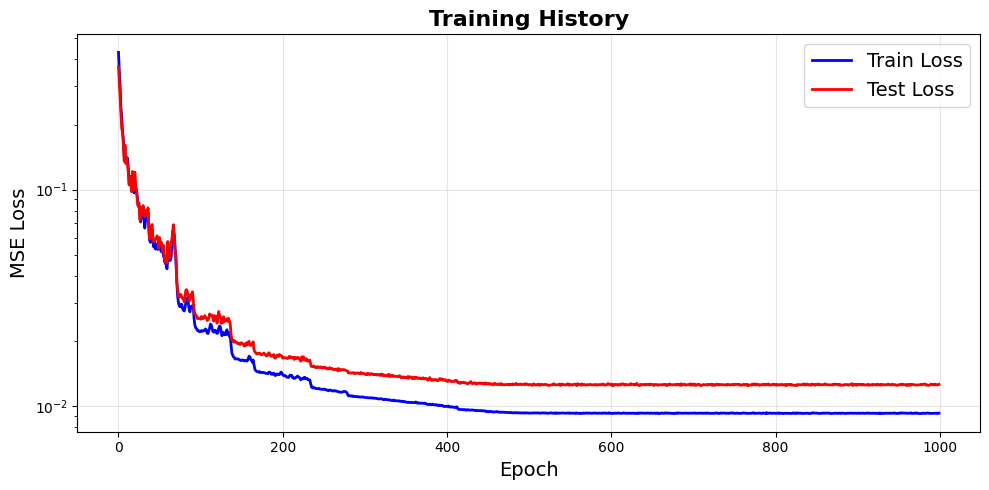

In [12]:

# ==========================================
# Training Loop
# ==========================================

train_losses = []
test_losses = []
best_test_loss = float('inf')
checkpoint_path = 'best_deeponet_burgers.pt'

# Trunk subsampling settings
subsample_size = 20000  # Number of trunk points per batch
total_trunk_points = train_dataset.trunk_data.shape[0]
print(f"Training with trunk subsampling: {subsample_size} / {total_trunk_points} points per step")

print("Starting training...\n")
start_time = time.time()

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss_epoch = 0.0

    for u0_batch, u_batch in train_loader:
        optimizer.zero_grad()

        # Randomly subsample trunk points for this batch
        if subsample_size < total_trunk_points:
            indices = torch.randint(0, total_trunk_points, (subsample_size,))
            trunk_batch = train_dataset.trunk_data[indices]
            u_target_batch = u_batch[:, indices]
        else:
            trunk_batch = train_dataset.trunk_data
            u_target_batch = u_batch

        # Forward pass
        u_pred = model(u0_batch, trunk_batch)
        loss = criterion(u_pred, u_target_batch)

        # Backward pass
        loss.backward()
        optimizer.step()

        train_loss_epoch += loss.item()

    train_loss_epoch /= len(train_loader)
    train_losses.append(train_loss_epoch)

    # Evaluation phase
    model.eval()
    test_loss_epoch = 0.0

    # Validation subsampling
    eval_subsample = min(50000, total_trunk_points)

    with torch.no_grad():
        indices = torch.randint(0, total_trunk_points, (eval_subsample,))
        trunk_val = test_dataset.trunk_data[indices]

        for u0_batch, u_batch in test_loader:
            u_target_val = u_batch[:, indices]

            u_pred = model(u0_batch, trunk_val)
            loss = criterion(u_pred, u_target_val)
            test_loss_epoch += loss.item()

    test_loss_epoch /= len(test_loader)
    test_losses.append(test_loss_epoch)

    # Learning rate scheduling
    scheduler.step(test_loss_epoch)

    # Save best model
    if test_loss_epoch < best_test_loss:
        best_test_loss = test_loss_epoch
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss_epoch,
            'test_loss': test_loss_epoch,
            'u0_mean': u0_mean,
            'u0_std': u0_std,
            'trunk_mean': trunk_mean,
            'trunk_std': trunk_std,
            'grid_info': grid_info
        }, checkpoint_path)

    # Print progress
    if (epoch + 1) % 100 == 0 or epoch == 0 or epoch == num_epochs-1:
        elapsed = time.time() - start_time
        print(f"Epoch [{epoch+1}/{num_epochs}] | "
              f"Train Loss: {train_loss_epoch:.6f} | "
              f"Test Loss: {test_loss_epoch:.6f} | "
              f"Time: {elapsed:.1f}s")

total_time = time.time() - start_time
print(f"\nTraining completed in {total_time:.1f} seconds ({total_time/60:.1f} minutes)")
print(f"Best test loss: {best_test_loss:.6f}")
print(f"Model saved to: {checkpoint_path}")

plot_loss(train_losses, test_losses, savefile='training_history.png')


In [14]:
# ==========================================
# Load Best Model and Evaluate
# ==========================================

# Load best checkpoint
checkpoint = torch.load(checkpoint_path, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"Loaded best model from epoch {checkpoint['epoch']+1}")
print(f"Best test loss: {checkpoint['test_loss']:.6f}\n")

# Predict on test set
print("Generating predictions on test set...")
predictions = []

with torch.no_grad():
    # Use the global trunk_tensor which was already defined and moved to device
    # (assuming trunk_tensor is already on the correct device from previous cells)
    trunk_coords_for_prediction = trunk_tensor.to(device) # Ensure it's on the correct device
    for i in range(len(test_dataset)):
        u0_sample, _ = test_dataset[i]
        u_pred = model(u0_sample.unsqueeze(0), trunk_coords_for_prediction).squeeze(0)
        predictions.append(u_pred.cpu().numpy())

predictions = np.array(predictions)
print(f"Predictions shape: {predictions.shape}")

# Compute relative L2 errors
u_test_np = u_test  # Already numpy array
test_errors = []
for i in range(len(u_test_np)):
    error = compute_relative_l2_error(predictions[i], u_test_np[i])
    test_errors.append(error)

test_errors = np.array(test_errors)
print(f"\nRelative L2 Error Statistics:")
print(f"  Mean: {test_errors.mean():.6f}")
print(f"  Std:  {test_errors.std():.6f}")
print(f"  Min:  {test_errors.min():.6f}")
print(f"  Max:  {test_errors.max():.6f}")
print(f"  Median: {np.median(test_errors):.6f}")


Loaded best model from epoch 603
Best test loss: 0.012347

Generating predictions on test set...
Predictions shape: (100, 819200)

Relative L2 Error Statistics:
  Mean: 0.161109
  Std:  0.030464
  Min:  0.103955
  Max:  0.264117
  Median: 0.158882


Grid dimensions: nx=64, ny=64, nt=200
Total trunk points per sample: 819200
Expected: 819200

Visualizing 4 test samples at 4 time snapshots
Time indices: [0, 66, 133, 199]
Time values: [np.float64(0.0), np.float64(0.3316582914572864), np.float64(0.6683417085427136), np.float64(1.0)]

Comparison plot saved to: comparison_4x4_grid.png


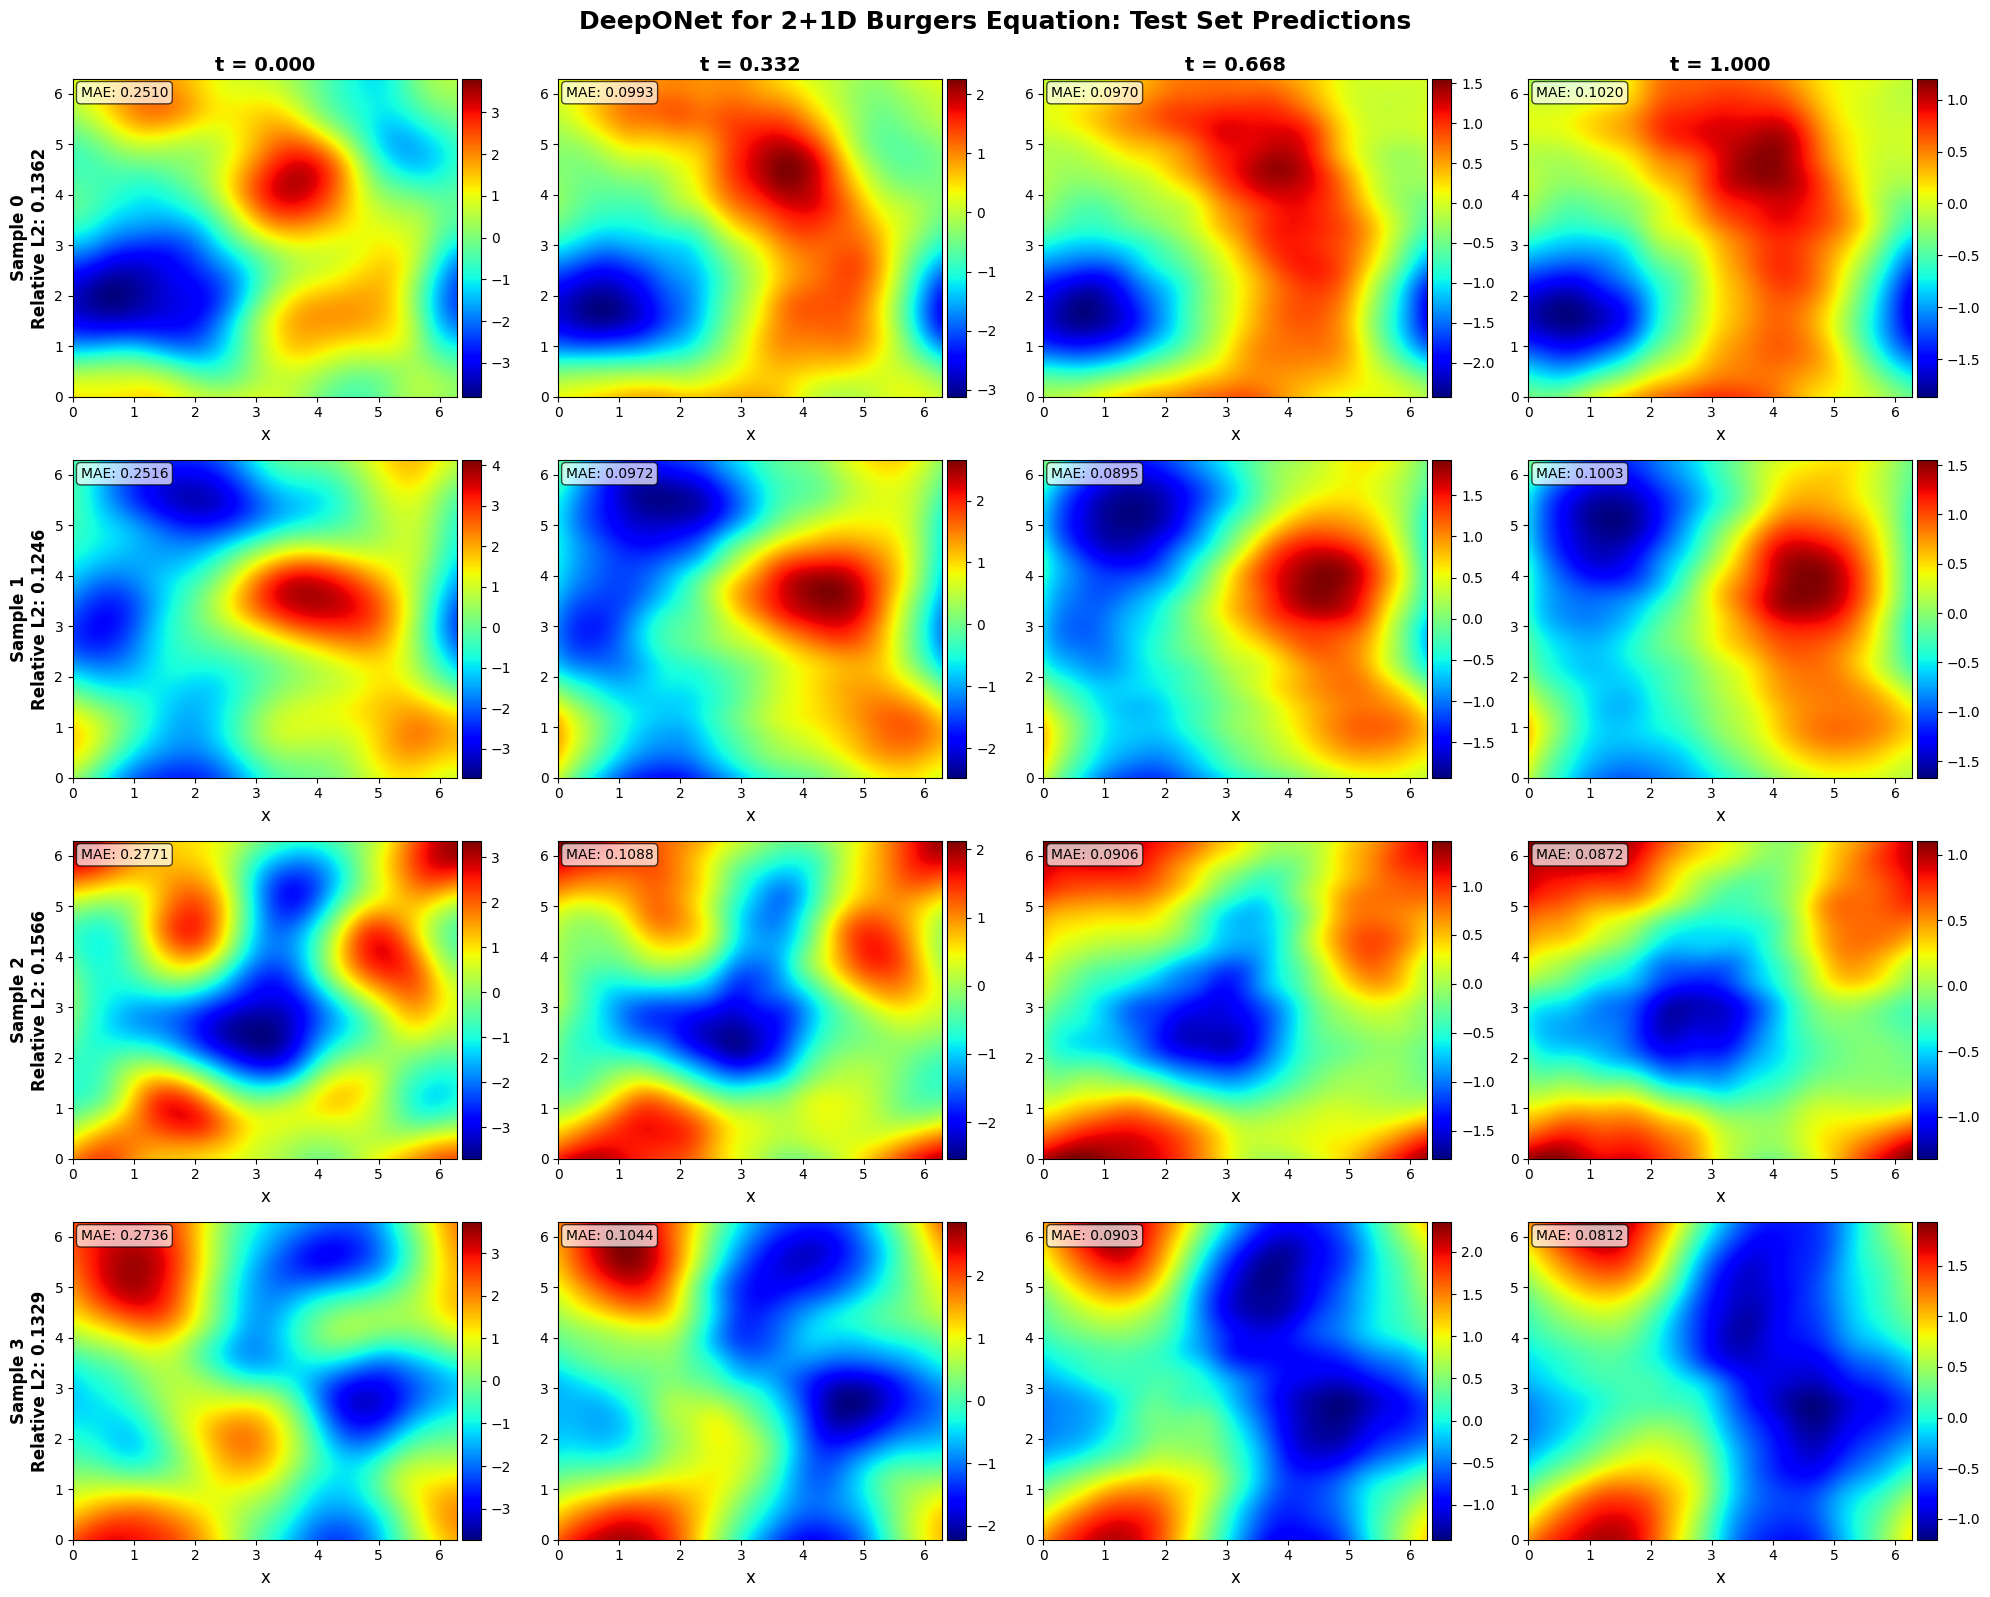

In [15]:


# ==========================================
# Main Comparison Visualization (4×4 Grid)
# ==========================================

# Extract spatial grid information
M = trunk_all.shape[0]
# Assume trunk is structured as (nx*ny*nt, 3)
# We need to determine nx, ny, nt from the trunk data
x_unique = np.unique(trunk_all[:, 0])
y_unique = np.unique(trunk_all[:, 1])
t_unique = np.unique(trunk_all[:, 2])

nx_grid = len(x_unique)
ny_grid = len(y_unique)
nt = len(t_unique)

print(f"Grid dimensions: nx={nx_grid}, ny={ny_grid}, nt={nt}")
print(f"Total trunk points per sample: {M}")
print(f"Expected: {nx_grid * ny_grid * nt}")

# Select test samples to visualize
num_samples = 4
sample_indices = [0, 1, 2, 3]  # First 4 test samples

# Select time snapshots to visualize
time_snapshots = [0, nt//3, 2*nt//3, nt-1]  # Early, mid1, mid2, final

print(f"\nVisualizing {num_samples} test samples at {len(time_snapshots)} time snapshots")
print(f"Time indices: {time_snapshots}")
print(f"Time values: {[t_unique[i] for i in time_snapshots]}")

# Create 4×4 grid visualization
fig, axes = plt.subplots(num_samples, len(time_snapshots), figsize=(20, 16))
fig.suptitle('DeepONet for 2+1D Burgers Equation: Test Set Predictions',
             fontsize=18, fontweight='bold', y=0.995)

for row, sample_idx in enumerate(sample_indices):
    # Get truth and prediction for this sample
    truth_full = u_test[sample_idx]  # Shape: (M,)
    pred_full = predictions[sample_idx]  # Shape: (M,)
    u0_sample = u0_test[sample_idx]  # Shape: (nx, ny)

    # Compute relative L2 error for this sample
    rel_error = compute_relative_l2_error(pred_full, truth_full)

    for col, t_idx in enumerate(time_snapshots):
        ax = axes[row, col]

        # Extract data at this time snapshot
        # Assuming data is ordered as [t0: all (x,y), t1: all (x,y), ...]
        start_idx = t_idx * nx_grid * ny_grid
        end_idx = start_idx + nx_grid * ny_grid

        truth_t = truth_full[start_idx:end_idx].reshape(nx_grid, ny_grid)
        pred_t = pred_full[start_idx:end_idx].reshape(nx_grid, ny_grid)

        # Plot prediction
        vmin = min(truth_t.min(), pred_t.min())
        vmax = max(truth_t.max(), pred_t.max())

        plot_2d_field(ax, pred_t, extent=[0, 2*np.pi, 0, 2*np.pi],
                     cmap='jet', vmin=vmin, vmax=vmax)

        # Add title with time and error info
        if row == 0:
            ax.set_title(f't = {t_unique[t_idx]:.3f}', fontsize=14, fontweight='bold')

        if col == 0:
            ax.set_ylabel(f'Sample {sample_idx}\nRelative L2: {rel_error:.4f}',
                         fontsize=12, fontweight='bold')
        else:
            ax.set_ylabel('')

        # Add text overlay showing truth vs pred difference
        point_error = np.abs(pred_t - truth_t).mean()
        ax.text(0.02, 0.98, f'MAE: {point_error:.4f}',
               transform=ax.transAxes, fontsize=10, verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

plt.tight_layout()
plt.savefig('comparison_4x4_grid.png', dpi=150, bbox_inches='tight')
print("\nComparison plot saved to: comparison_4x4_grid.png")
plt.show()



Detailed analysis for test sample 0
Time snapshots: [np.float64(0.0), np.float64(0.3316582914572864), np.float64(0.6633165829145728), np.float64(1.0)]
Detailed comparison saved to: detailed_comparison.png


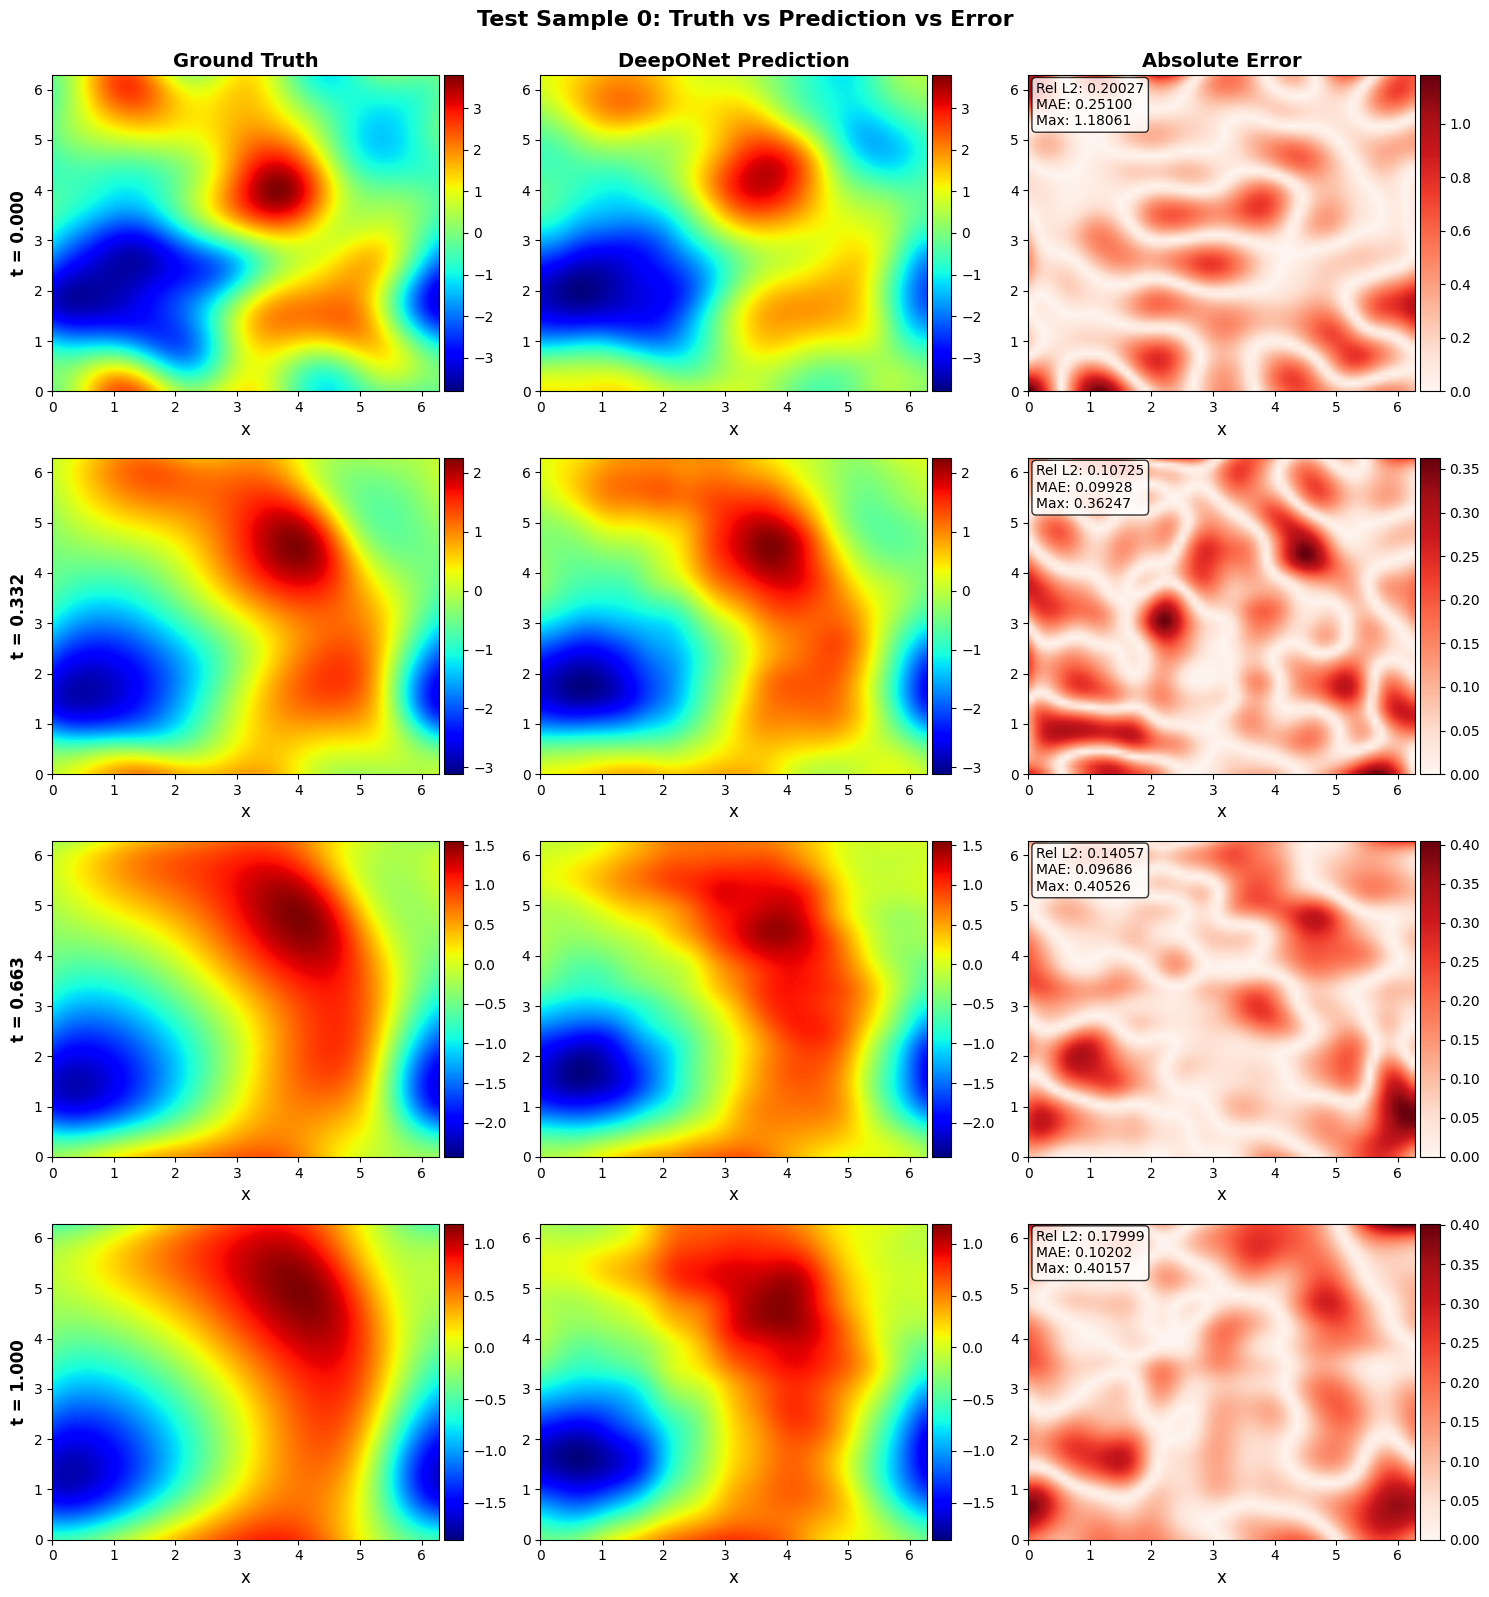

In [16]:

# ==========================================
# Detailed Comparison: Truth, Prediction, Error
# ==========================================

# Select one sample for detailed analysis
detail_sample_idx = 0
num_time_snapshots = 4
time_indices_detail = np.linspace(0, nt-1, num_time_snapshots, dtype=int)

truth_detail = u_test[detail_sample_idx]
pred_detail = predictions[detail_sample_idx]
u0_detail = u0_test[detail_sample_idx]

print(f"Detailed analysis for test sample {detail_sample_idx}")
print(f"Time snapshots: {[t_unique[i] for i in time_indices_detail]}")

fig, axes = plt.subplots(num_time_snapshots, 3, figsize=(15, 16))
fig.suptitle(f'Test Sample {detail_sample_idx}: Truth vs Prediction vs Error',
             fontsize=16, fontweight='bold', y=0.995)

for row, t_idx in enumerate(time_indices_detail):
    # Extract data at this time
    start_idx = t_idx * nx_grid * ny_grid
    end_idx = start_idx + nx_grid * ny_grid

    truth_t = truth_detail[start_idx:end_idx].reshape(nx_grid, ny_grid)
    pred_t = pred_detail[start_idx:end_idx].reshape(nx_grid, ny_grid)
    error_t = np.abs(truth_t - pred_t)

    # Global color limits for truth and prediction
    vmin = min(truth_t.min(), pred_t.min())
    vmax = max(truth_t.max(), pred_t.max())

    # Truth
    ax = axes[row, 0]
    plot_2d_field(ax, truth_t, cmap='jet', vmin=vmin, vmax=vmax)
    if row == 0:
        ax.set_title('Ground Truth', fontsize=14, fontweight='bold')
    ax.set_ylabel(f't = {t_unique[t_idx]:.3f}', fontsize=12, fontweight='bold')

    # Prediction
    ax = axes[row, 1]
    plot_2d_field(ax, pred_t, cmap='jet', vmin=vmin, vmax=vmax)
    if row == 0:
        ax.set_title('DeepONet Prediction', fontsize=14, fontweight='bold')
    ax.set_ylabel('')

    # Absolute Error
    ax = axes[row, 2]
    plot_2d_field(ax, error_t, cmap='Reds', vmin=0, vmax=error_t.max())
    if row == 0:
        ax.set_title('Absolute Error', fontsize=14, fontweight='bold')
    ax.set_ylabel('')

    # Add error statistics
    rel_l2 = compute_relative_l2_error(pred_t.flatten(), truth_t.flatten())
    mae = error_t.mean()
    max_err = error_t.max()
    ax.text(0.02, 0.98, f'Rel L2: {rel_l2:.5f}\nMAE: {mae:.5f}\nMax: {max_err:.5f}',
           transform=ax.transAxes, fontsize=10, verticalalignment='top',
           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig('detailed_comparison.png', dpi=150, bbox_inches='tight')
print("Detailed comparison saved to: detailed_comparison.png")
plt.show()




Analyzing temporal evolution of prediction error...

Temporal evolution plot saved to: temporal_evolution.png


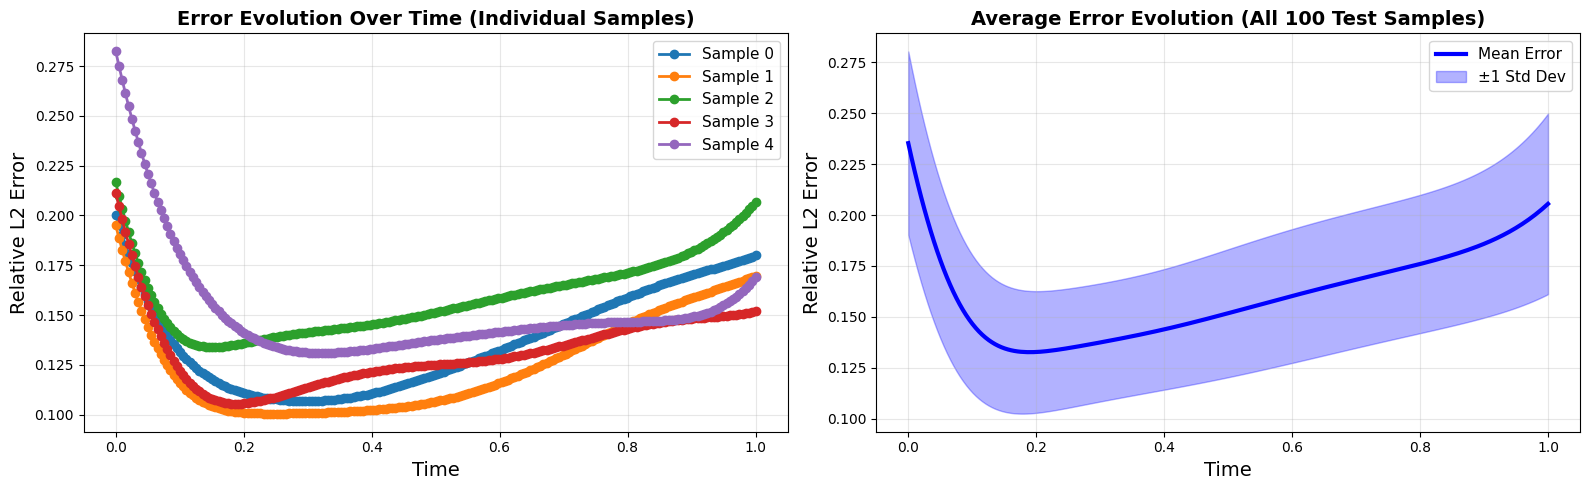


Temporal Error Statistics:
  Initial time (t=0.000): mean=0.235298, std=0.045024
  Final time (t=1.000): mean=0.205490, std=0.044343
  Maximum mean error over time: 0.235298 at t=0.000
  Minimum mean error over time: 0.132669 at t=0.191


In [17]:
# ==========================================
# Temporal Evolution Analysis
# ==========================================

# Analyze how prediction error evolves over time
print("Analyzing temporal evolution of prediction error...\n")

# Select a few test samples to analyze
analysis_samples = [0, 1, 2, 3, 4]
errors_over_time = np.zeros((len(analysis_samples), nt))

for i, sample_idx in enumerate(analysis_samples):
    truth_sample = u_test[sample_idx]
    pred_sample = predictions[sample_idx]

    for t_idx in range(nt):
        start_idx = t_idx * nx_grid * ny_grid
        end_idx = start_idx + nx_grid * ny_grid

        truth_t = truth_sample[start_idx:end_idx]
        pred_t = pred_sample[start_idx:end_idx]

        rel_error_t = compute_relative_l2_error(pred_t, truth_t)
        errors_over_time[i, t_idx] = rel_error_t

# Plot temporal evolution
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Individual sample trajectories
ax = axes[0]
for i, sample_idx in enumerate(analysis_samples):
    ax.plot(t_unique, errors_over_time[i], marker='o', label=f'Sample {sample_idx}',
            linewidth=2, markersize=6)
ax.set_xlabel('Time', fontsize=14)
ax.set_ylabel('Relative L2 Error', fontsize=14)
ax.set_title('Error Evolution Over Time (Individual Samples)', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# Average and statistics across all test samples
ax = axes[1]
all_errors_over_time = np.zeros((len(test_errors), nt))

for sample_idx in range(len(u_test)):
    truth_sample = u_test[sample_idx]
    pred_sample = predictions[sample_idx]

    for t_idx in range(nt):
        start_idx = t_idx * nx_grid * ny_grid
        end_idx = start_idx + nx_grid * ny_grid

        truth_t = truth_sample[start_idx:end_idx]
        pred_t = pred_sample[start_idx:end_idx]

        rel_error_t = compute_relative_l2_error(pred_t, truth_t)
        all_errors_over_time[sample_idx, t_idx] = rel_error_t

mean_errors = all_errors_over_time.mean(axis=0)
std_errors = all_errors_over_time.std(axis=0)

ax.plot(t_unique, mean_errors, 'b-', linewidth=3, label='Mean Error')
ax.fill_between(t_unique, mean_errors - std_errors, mean_errors + std_errors,
                alpha=0.3, color='blue', label='±1 Std Dev')
ax.set_xlabel('Time', fontsize=14)
ax.set_ylabel('Relative L2 Error', fontsize=14)
ax.set_title(f'Average Error Evolution (All {len(u_test)} Test Samples)',
            fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('temporal_evolution.png', dpi=150, bbox_inches='tight')
print("Temporal evolution plot saved to: temporal_evolution.png")
plt.show()

# Print summary statistics
print(f"\nTemporal Error Statistics:")
print(f"  Initial time (t={t_unique[0]:.3f}): mean={all_errors_over_time[:, 0].mean():.6f}, std={all_errors_over_time[:, 0].std():.6f}")
print(f"  Final time (t={t_unique[-1]:.3f}): mean={all_errors_over_time[:, -1].mean():.6f}, std={all_errors_over_time[:, -1].std():.6f}")
print(f"  Maximum mean error over time: {mean_errors.max():.6f} at t={t_unique[mean_errors.argmax()]:.3f}")
print(f"  Minimum mean error over time: {mean_errors.min():.6f} at t={t_unique[mean_errors.argmin()]:.3f}")